<a href="https://colab.research.google.com/github/kuir-juach/Time-Series-Forecasting/blob/main/Air_Quality_Forecasting_in_Beijing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Beijing Air Quality Forecasting Notebook**

In [1]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')

# **Explore the training data**
In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


**1. Time Series Trend visualization for PM2.5:**

The plot shows the trend of PM2.5 concentrations over time.
PM2.5 refers to fine particulate matter in the air, which is a key indicator of air quality.

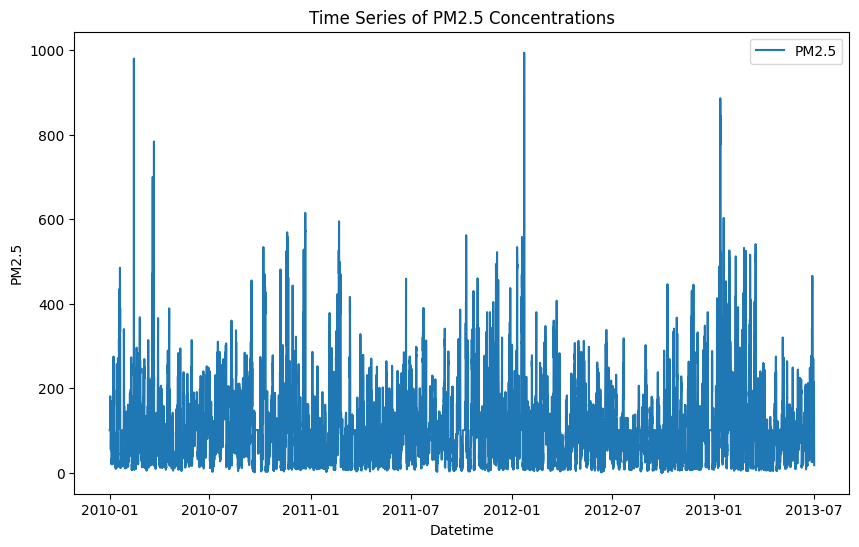

In [11]:
# Visualization: Time series trend for PM2.5
plt.figure(figsize=(10, 6))
# Access the datetime information from the index of the DataFrame
plt.plot(train.index, train['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


**Interpretation of the above Result.**

High PM2.5 concentrations (e.g., values close to 1000) indicate poor air quality, which could be due to factors like industrial activity, vehicle emissions, or weather conditions.

If the plot shows consistent spikes at certain times (e.g., winter months), it might suggest seasonal pollution sources, such as heating or reduced air dispersion.

**2. Correlation Matrix of Features:**
The correlation matrix shows the relationships (correlations) between different features in the dataset.


Correlation values range from -1 to 1

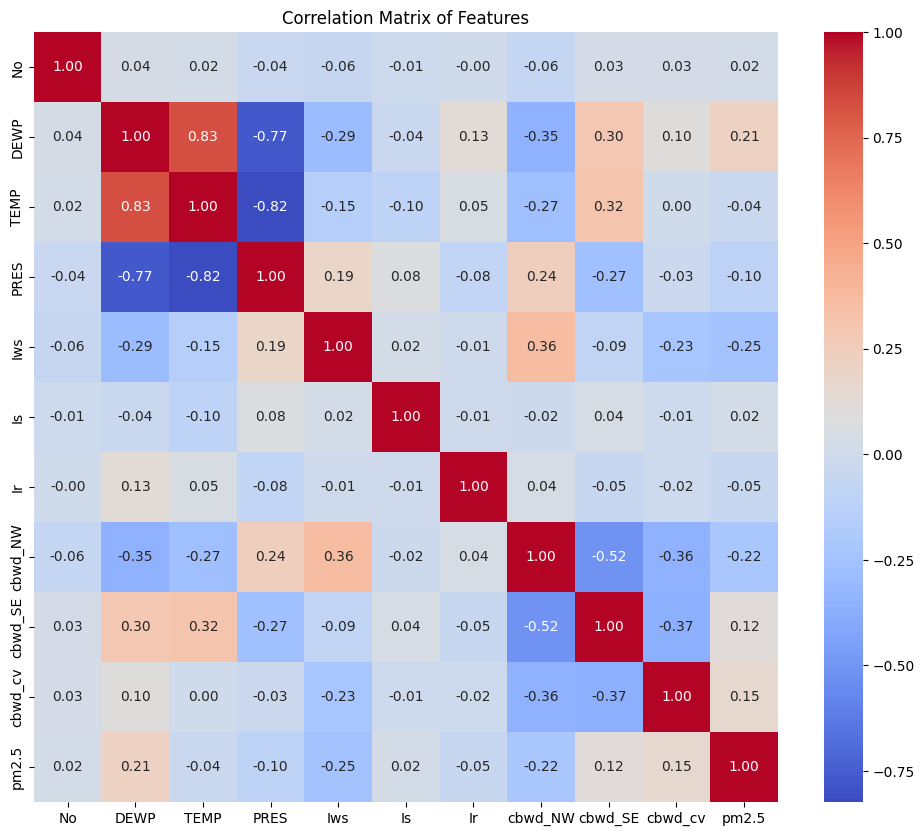

In [12]:
import seaborn as sns
import pandas as pd

plt.figure(figsize=(12, 10))
# Exclude non-numeric columns before calculating correlations
correlation_matrix = train.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

**Interpretation of the Result**

The strong negative correlation between DEWP and TEMP is expected, as dew point and temperature are inversely related in many climates.

The weak correlations with pm2.5 suggest that other factors (not included in this matrix) might be more influential in determining PM2.5 levels, such as traffic, industrial activity, or geographic location.

**3. Box Plot of Features to Identify Outliers**

The box plot visualize the distribution of data for different features and identify potential outliers.
Outliers are data points that fall significantly outside the typical range of values.

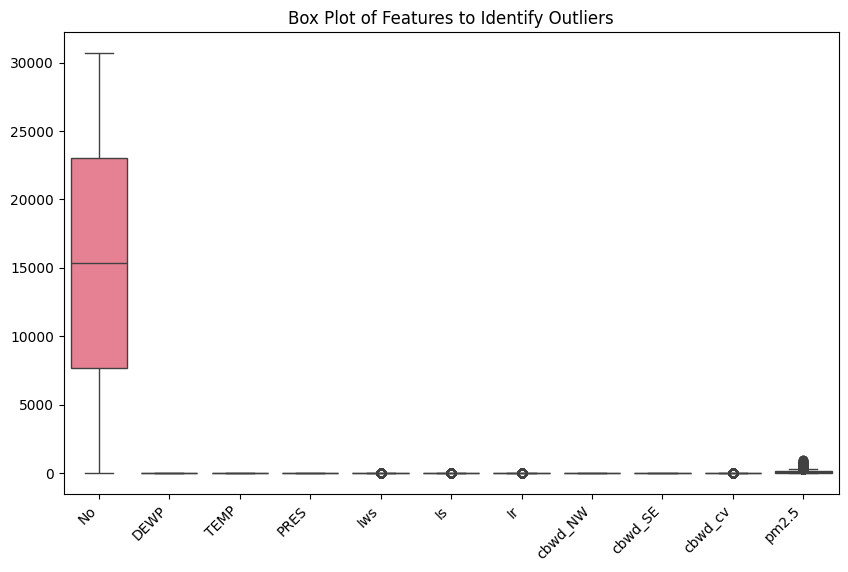

In [13]:
# Checking for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=train)
plt.title('Box Plot of Features to Identify Outliers')
plt.xticks(rotation=45, ha='right')
plt.show()

**Interpretation of the Result**

If outliers are present, they could indicate errors in data collection, extreme events, or unique cases that deviate from the norm.

For example, if pm2.5 has outliers with extremely high values, it could indicate days with severe air pollution due to specific events.

Identifying outliers is important because they can skew analysis and modeling results, and may need to be addressed (e.g., removed or transformed).

In [14]:
# Checking for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())


Missing values in training data:
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
dtype: int64


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# **Handle missing values**
- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# **Separate features and target**
- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [8]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [9]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# **Build model**
Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [19]:
from tensorflow.keras.regularizers import l2

# Define the LSTM model
# Experiment: L2 regularization, ReLU activation
# LSTM layer with L2 regularization
# Dropout layer for regularization
model_1 = Sequential()
model_1.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model_1.add(Dropout(0.2))
model_1.add(LSTM(64, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(Dropout(0.2))
model_1.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(Dense(1))

#Compile the model
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])

#Display model summary
model_1.summary()
history_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - lambda: 97.7250 - loss: 10552.2168
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - lambda: 73.3790 - loss: 5685.9570
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - lambda: 72.6164 - loss: 5581.8750
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 71.3991 - loss: 5435.6133
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - lambda: 71.2488 - loss: 5375.4966
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - lambda: 71.6165 - loss: 5445.2271
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - lambda: 72.6420 - loss: 5637.3281
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 71.3085 - loss: 5396.0874
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - lambda: 70.9532 - loss: 5332.8809
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - lambda: 70.9759 - loss: 5357.9375


959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


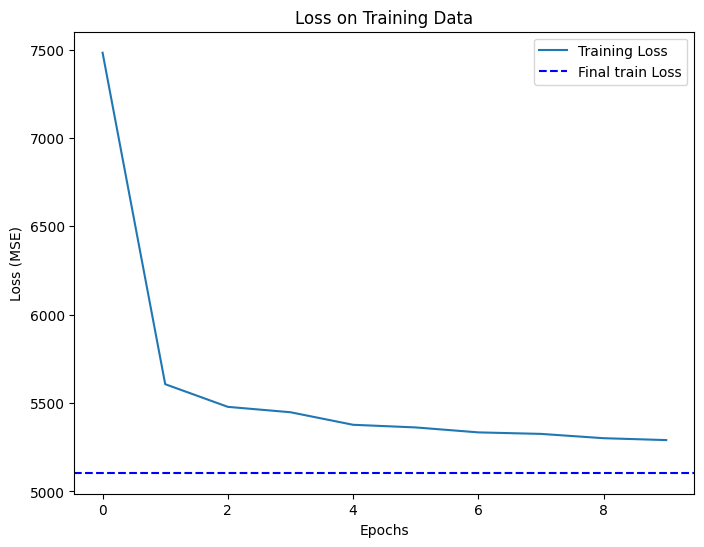

Final Training Loss (MSE): 5105.704522004915
Final Training Loss (RMSE): 71.45421276597283


In [20]:
# Calculate training loss
train_predictions = model_1.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)
train_loss_RSME = np.sqrt(train_loss)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final Training Loss (RMSE): {train_loss_RSME}")

In [23]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
# Change 'model' to 'model_1' to match the name of the trained model
predictions = model_1.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')
# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed12.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
